In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    run_dbscan, 
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)



In [2]:
rfm_cliente_local = pd.read_csv('../../../dataset/rfm_clientes_locales.csv')

print("cantidad de columnas: ", len(rfm_cliente_local.columns))

print("cantidad de filas: ", len(rfm_cliente_local))

cantidad de columnas:  18
cantidad de filas:  3915


In [3]:
id_cliente= rfm_cliente_local['id_cliente'].copy()

id_cliente.head()

0    12747.0
1    12748.0
2    12749.0
3    12820.0
4    12821.0
Name: id_cliente, dtype: float64

In [4]:
rfm_cliente_local.drop(columns=['id_cliente'], inplace=True)

In [5]:
rfm_cliente_local.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12'],
      dtype='object')

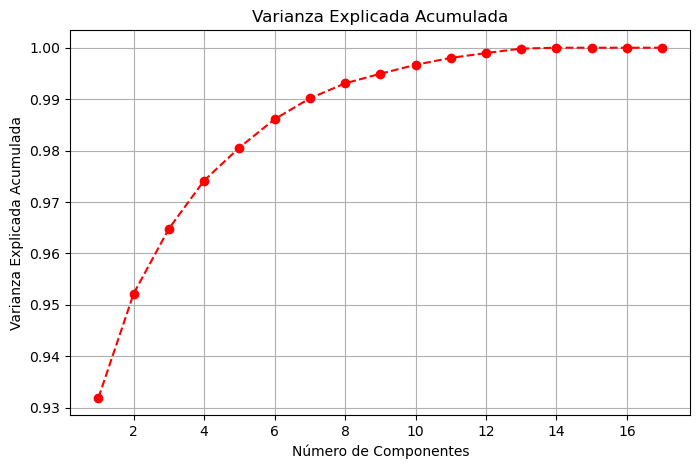

In [6]:
pca=PCA()

pca.fit(rfm_cliente_local)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()

In [7]:
componentes = transform_pca(rfm_cliente_local, 2)

# dichas compoenentes la transformamos en un dataframe de pandas , con los mismos indices que el dataframe original , para hacer un analisis psoteriormente de los grupos que forma k-means
dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2'],index=rfm_cliente_local.index)

dataframe_pca.head()

,PC1,PC2
0,-0.242707,-0.051309
1,-0.303196,0.089286
2,-0.239657,-0.050739
3,-0.237640,0.027036
4,0.325594,0.188650


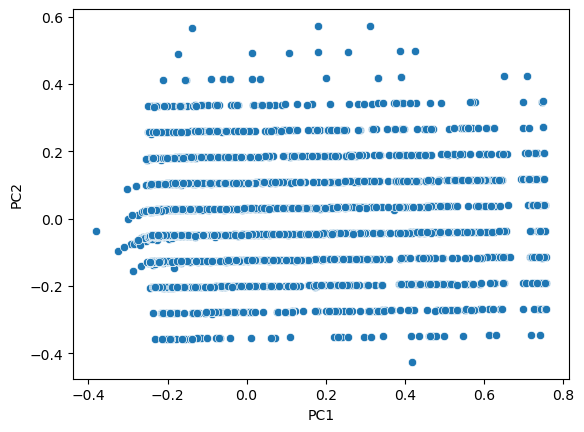

In [11]:
sns.scatterplot(x='PC1', y='PC2', data=dataframe_pca)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import optuna
def objective(trial):
    eps = trial.suggest_float('eps', 0.1, 5, step=0.1)
    min_samples = trial.suggest_int('min_samples', 1, 10)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(dataframe_pca.values)

    # Filtrar casos con solo ruido o un único clúster
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        return -9999.0  # Penalización fuerte

    X = dataframe_pca.values

    silhouette = silhouette_score(dataframe_pca.values, labels)
    calinski = calinski_harabasz_score(dataframe_pca.values, labels)
    davies = davies_bouldin_score(dataframe_pca.values, labels)

    # Normalizamos CH (opcional) y restamos DB
    # Pesos: silhouette (60%), calinski (40%), davies (-20%)
    score = (
        0.6 * silhouette +
        0.4 * (calinski / 100) - 
        0.2 * davies
    )

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)

print("\nMejor puntuación compuesta obtenida:")
print(study.best_value)


[I 2025-07-12 16:23:31,759] A new study created in memory with name: no-name-5bbcd89f-97fd-4e83-a644-560b84851244
/home/agustin/miniconda3/envs/ecommerce/lib/python3.9/site-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [0.1, 30] and step=0.2, but the range is not divisible by `step`. It will be replaced by [0.1, 29.9].
  warnings.warn(
[I 2025-07-12 16:23:32,255] Trial 0 finished with value: -9999.0 and parameters: {'eps': 28.500000000000004, 'min_samples': 31}. Best is trial 0 with value: -9999.0.
/home/agustin/miniconda3/envs/ecommerce/lib/python3.9/site-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [0.1, 30] and step=0.2, but the range is not divisible by `step`. It will be replaced by [0.1, 29.9].
  warnings.warn(
[I 2025-07-12 16:23:32,561] Trial 1 finished with value: -9999.0 and parameters: {'eps': 19.900000000000002, 'min_samples': 40}. Best is trial 0 with value: -9999.0.
/home/agustin/miniconda3/envs/

Mejores hiperparámetros encontrados:
{'eps': 28.500000000000004, 'min_samples': 31}

Mejor puntuación compuesta obtenida:
-9999.0


In [ ]:
data_clust = run_dbscan(dataframe_pca, 0.1, 31 ,experiment_name="DBSCAN_Clientes_Locales")

data_clust.head()